In [1]:
import os
import pandas as pd
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Data Location within CC DS
data_location = os.path.join("..","data","external")

#######################################################
# Create Lists of Columns for Subsetting Data for Analysis
# Create Mapping of Column Names for Cleanliness
#

compset_sdr_list = ['Date',
                    'Region',
                    'Supply-Total',
                    'Demand-Trans.',
                    'Demand-Grp.',
                    'Demand-Con.',
                    'Demand-Total',
                    'Revenue-Trans.',
                    'Revnue-Grp.',
                    'Revenue-Con.',
                    'Revenue-Total']

compset_sdr_mapping = {
                   'Supply-Total':'S-Total',
                   'Demand-Trans.':'D-Trans',
                   'Demand-Grp.':'D-Grp',
                   'Demand-Con.':'D-Con',
                   'Demand-Total':'D-Total',
                   'Revenue-Trans.': 'R-Trans',
                   'Revenue-Grp.':'R-Grp',
                   'Revenue-Con.':'R-Con',
                   'Revenue-Total':'R-Total'
                    }

compset_oar_list = ['Date',
                   'Region',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

compset_oar_list = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR-TRANS',
                   'ADR-Grp.':'ADR-GRP',
                   'ADR-Cont.':'ADR-CONT',
                   'ADR-Total':'ADR-TOTAL',
                   'RevPAR-Trans.':'RevPAR-TRANS',
                   'RevPAR-Grp.':'RevPAR-GRP',
                   'RevPAR-Cont.':'RevPAR-CONT',
                    'RevPAR-Total':'RevPAR-TOTAL'
                    }


m_cnty_sdr_list = ['Year',
               'Month',
               'Region',
               'Supply-Total',
               'Demand-Total',
               'Revenue-Total']

m_cnty_sdr_mapping = {
                'Supply-Total':'S-Total',
                'Demand-Total':'D-Total',
                'Revenue-Total':'R-Total'
                }

totals_analysis_list = ['S-Total',
                        'D-Total',
                        'R-Total',
                        'Month',
                        'Year',
                        'Date',
                        'Region']

# Read in Monterey County XLS
#
# Documentation for Monterey County XLS goes here...
file_path = os.path.join(data_location, "Monterey-County-City-STR-ALL.xlsx")
m_cnty = pd.read_excel(file_path, sheetname = "County of Monterey 05-16 Seg")
m_cty = pd.read_excel(file_path, sheetname = "City of Monterey 00-16 Agg")

# Read in Compset data
file_path = os.path.join(data_location, "Comp-Set-STR-ALL.xlsx")
compset_hm = pd.read_excel(file_path, sheetname = "Comp-Set OCC-ADR-RevPARv2")
compset_sdr = pd.read_excel(file_path, sheetname = "Comp-Set S-D-Rv3")

In [2]:
###################################################
# Process monterey_county
m_cnty['Region'] = 'Monterey County, CA'
m_cnty = m_cnty[m_cnty_sdr_list]
m_cnty = m_cnty.rename(columns=m_cnty_sdr_mapping)


m_cnty['Month'] = m_cnty['Month'].apply(str)
m_cnty['Year'] = m_cnty['Year'].apply(str)
m_cnty['Date'] = m_cnty['Year'] + "-" + m_cnty['Month']
m_cnty['Date'] = pd.to_datetime(m_cnty['Date'], format = "%Y-%b")

m_cnty = m_cnty[totals_analysis_list]

In [3]:
###################################################
# Process compset_sdr
compset_sdr_v1 = compset_sdr[compset_sdr_list]
compset_sdr_v1 = compset_sdr_v1.rename(columns=compset_sdr_mapping)

#Date & Time Manipulation
compset_sdr_v1['Date'] = pd.to_datetime(compset_sdr_v1['Date'])
compset_sdr_v1['Month'] = compset_sdr_v1['Date'].apply(lambda x: x.month)
compset_sdr_v1['Year'] = compset_sdr_v1['Date'].apply(lambda x: x.year)

#String Manipulation
compset_sdr_v1['Region'] = compset_sdr_v1['Region'].str.replace('+','')

# What is Monterey's Share of Total Demand & Revenue by Year Amongst it's compset for that time period.
# This is the spot where we grab only the Supply, Demand, & Revenue Totals for analysis. 
compset_sdr_v1 = compset_sdr_v1[totals_analysis_list] # I have to conform to the m_cnty columns for a clean append*


In [4]:
####################################################
# Combine the datasets for Econ Metrics
compset_sdr_v2 = compset_sdr_v1.append(m_cnty)

# Compset Year Month Group
c_year_month = compset_sdr_v1.groupby(['Year','Month'])
c_total_revenue = c_year_month["S-Total","D-Total","R-Total"].aggregate(sum)
c_total_revenue = c_total_revenue.reset_index()

# DataFrame Total Includes everything needed for basic calculations and analysis. Further may be necessary
df_tot = pd.merge(compset_sdr_v1, c_total_revenue, on = ["Month","Year"], suffixes = ("OA"))

In [7]:
####################################################
# Begin Analysis and Subsetting
# Starting with basic Revenue Share & Demand Share 

df_tot = df_tot[df_tot['Date'] > '2012-01-01']

df_tot['Revenue_share'] = df_tot['R-TotalO']/df_tot['R-TotalA']
df_tot['Demand_share']  = df_tot['D-TotalO']/df_tot['D-TotalA']

df_tot['Revenue_share_ann'] = df_tot.groupby(['Region'])['Revenue_share'].pct_change(12)
df_tot['Revenue_share_mom'] = df_tot.groupby(['Region'])['Revenue_share'].pct_change(1)
df_tot['Demand_share_ann']  = df_tot.groupby(['Region'])['Demand_share'].pct_change(12)
df_tot['Demand_share_mom']  = df_tot.groupby(['Region'])['Demand_share'].pct_change(1)




#df_tot.to_csv("total_shares.csv",index = False)

,S-TotalO,D-TotalO,R-TotalO,Month,Year,Date,Region,S-TotalA,D-TotalA,R-TotalA,Revenue_share,Demand_share,Revenue_share_ann,Revenue_share_mom,Demand_share_ann,Demand_share_mom
47,171416,95860.0,8998140.0,2,2012,2012-02-01,"Sonoma County, CA",1003268,570671.0,7.981152e+07,0.112742,0.167978,NaN,NaN,NaN,NaN
48,125020,66773.0,12145106.0,2,2012,2012-02-01,"Napa County, CA",1003268,570671.0,7.981152e+07,0.152172,0.117008,NaN,NaN,NaN,NaN
49,253260,150186.0,20381684.0,2,2012,2012-02-01,"Santa Barbara County, CA",1003268,570671.0,7.981152e+07,0.255373,0.263174,NaN,NaN,NaN,NaN
50,322784,177541.0,26810140.0,2,2012,2012-02-01,"Monterey County, CA",1003268,570671.0,7.981152e+07,0.335918,0.311109,NaN,NaN,NaN,NaN
51,130788,80311.0,11476449.0,2,2012,2012-02-01,"City of Monterey, CA",1003268,570671.0,7.981152e+07,0.143794,0.140731,NaN,NaN,NaN,NaN
52,189782,112973.0,11189529.0,3,2012,2012-03-01,"Sonoma County, CA",1110792,663270.0,9.080807e+07,0.123222,0.170327,NaN,0.092950,NaN,0.013988
53,138446,80522.0,15632442.0,3,2012,2012-03-01,"Napa County, CA",1110792,663270.0,9.080807e+07,0.172148,0.121402,NaN,0.131271,NaN,0.037550
54,280395,180655.0,24194220.0,3,2012,2012-03-01,"Santa Barbara County, CA",1110792,663270.0,9.080807e+07,0.266432,0.272370,NaN,0.043308,NaN,0.034942
55,357368,200014.0,28566547.0,3,2012,2012-03-01,"Monterey County, CA",1110792,663270.0,9.080807e+07,0.314582,0.301557,NaN,-0.063517,NaN,-0.030702
56,144801,89106.0,11225337.0,3,2012,2012-03-01,"City of Monterey, CA",1110792,663270.0,9.080807e+07,0.123616,0.134343,NaN,-0.140328,NaN,-0.045387


C:\Users\Cloud User\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


ValueError: invalid literal for float(): 2016-8

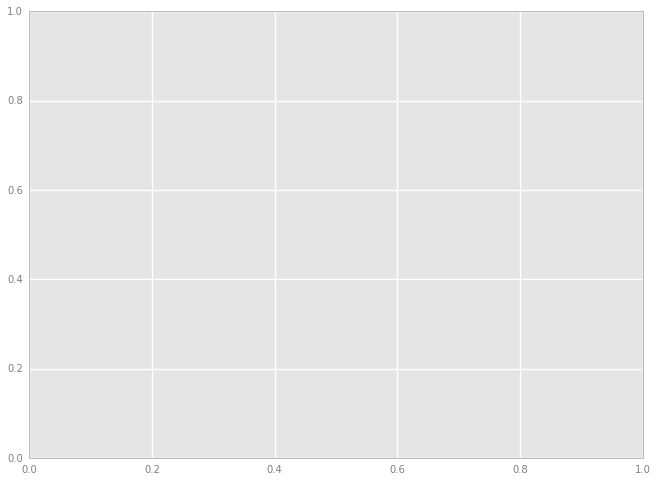

In [6]:
monterey_share = df_tot[df_tot['Region'] == "Monterey County, CA"]
#monterey_share['Date'] = monterey_share['Date'].apply(str)
monterey_share['Month-Year'] = monterey_share['Date'].apply(lambda x: str(x.year) + "-" + str(x.month))

m_share = ggplot(aes(x="Month-Year",y="Demand_share_mom"), data = monterey_share)
m_share = m_share + geom_line()# + scale_x_date(labels=date_format('%Y-%m-%d'))
m_share.show()


labels = monterey_share['Month-Year'].apply(str).tolist()
#plt.plot(monterey_share['Demand_share'])
#plt.xaxis.set_major
#plt.xticks(np.arange(min(labels),max(labels)),labels)
#plt.show()



In [ ]:
""